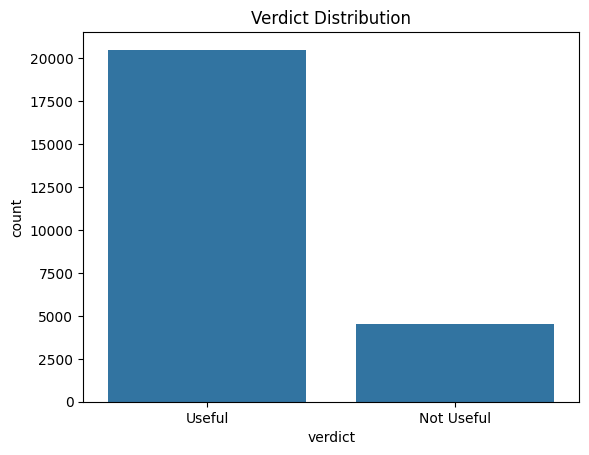

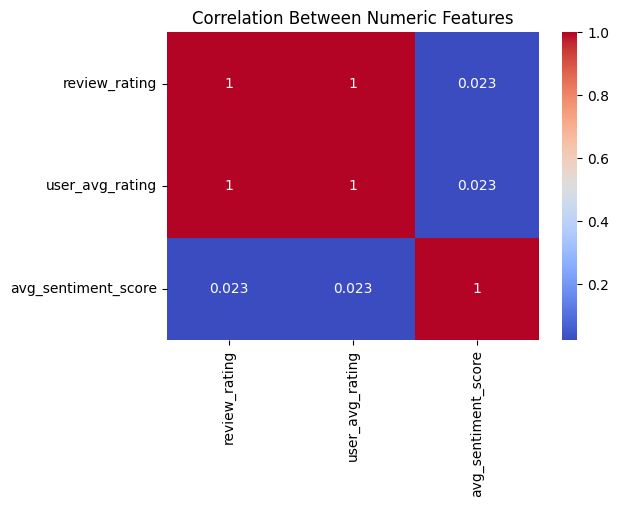

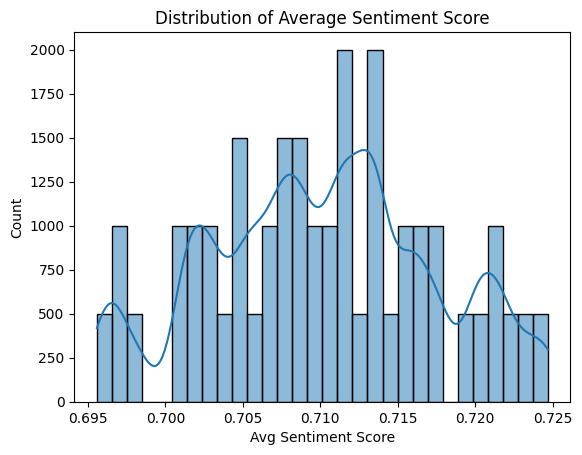

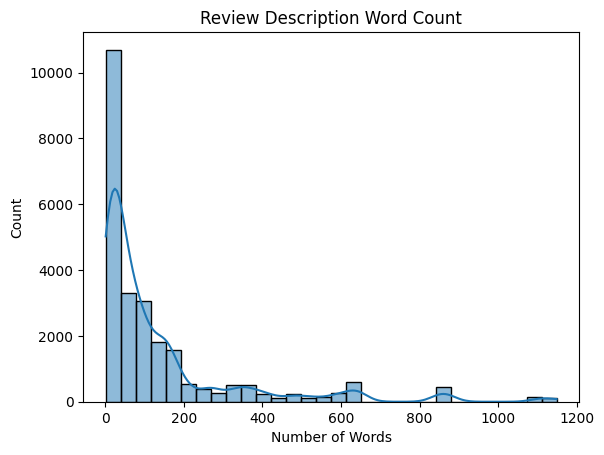


Training Random Forest...


<Figure size 1000x600 with 0 Axes>

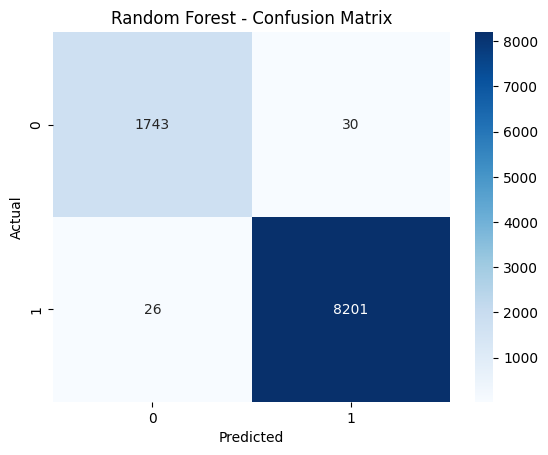

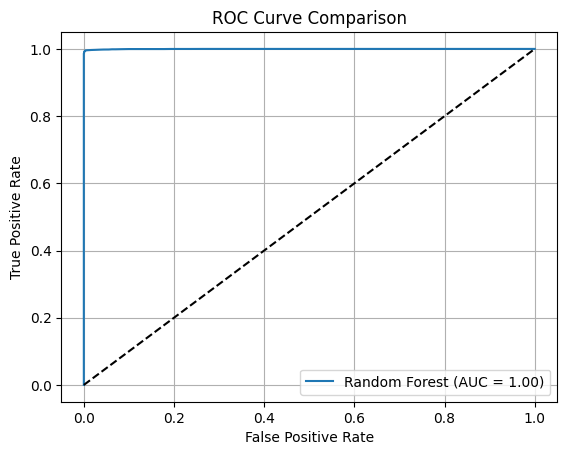


Final Model Comparison:
           Model  Accuracy  Precision   Recall  F1-Score   ROC AUC
0  Random Forest    0.9944   0.996355  0.99684  0.996597  0.999756
Model evaluation results saved as 'model_evaluation_results.csv'
Training data saved as 'training_data.csv'


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Load data
data = pd.read_csv("data.csv")
sentiment_summary = pd.read_csv("product_sentiment_analysis_combined.csv")
overall_summary = pd.read_csv("product_overall_sentiment_summary.csv")

# Merge datasets
merged = pd.merge(data, sentiment_summary, on="product_id")
merged = pd.merge(merged, overall_summary[['product_id', 'top_appreciated_aspects', 'top_criticized_aspects']], on='product_id', how='left')
merged.fillna("", inplace=True)

# Feature engineering
merged["user_avg_rating"] = merged.groupby("user_name")["review_rating"].transform("mean")
merged["avg_sentiment_score"] = pd.to_numeric(merged["avg_sentiment_score"], errors="coerce").fillna(0)
merged["full_text"] = (
    merged["review_title"].astype(str) + " " +
    merged["review_description"].astype(str) + " " +
    merged["top_appreciated_aspects"].astype(str) + " " +
    merged["top_criticized_aspects"].astype(str)
)
merged["target"] = merged["verdict"].map({"Useful": 1, "Not Useful": 0})

# 1. Verdict Distribution
sns.countplot(data=merged, x="verdict")
plt.title("Verdict Distribution")
plt.savefig("verdict_distribution.png")
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(merged[["review_rating", "user_avg_rating", "avg_sentiment_score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Numeric Features")
plt.savefig("correlation_heatmap.png")
plt.show()

# 3. Sentiment Score Distribution
sns.histplot(merged["avg_sentiment_score"], kde=True, bins=30)
plt.title("Distribution of Average Sentiment Score")
plt.xlabel("Avg Sentiment Score")
plt.savefig("sentiment_score_distribution.png")
plt.show()

# 4. Review Description Length Distribution
merged["review_length"] = merged["review_description"].apply(lambda x: len(str(x).split()))
sns.histplot(merged["review_length"], bins=30, kde=True)
plt.title("Review Description Word Count")
plt.xlabel("Number of Words")
plt.savefig("review_wordcount_distribution.png")
plt.show()

# Define features and target
X = merged[["review_rating", "user_avg_rating", "avg_sentiment_score", "full_text"]]
y = merged["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("text", TfidfVectorizer(max_features=5000), "full_text"),
    ("num", StandardScaler(), ["review_rating", "user_avg_rating", "avg_sentiment_score"])
])

# Model(s)
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=50, max_features="sqrt", random_state=42, n_jobs=-1),
}

# Training and Evaluation
results = []
plt.figure(figsize=(10, 6))
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC AUC": auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve_comparison.png")
plt.show()

# Summary table
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
print(results_df.sort_values("F1-Score", ascending=False).reset_index(drop=True))

# Save results
results_df.to_csv("model_evaluation_results.csv", index=False)
print("Model evaluation results saved as 'model_evaluation_results.csv'")

X_train_copy = X_train.copy()
X_train_copy["target"] = y_train.values
X_train_copy.to_csv("training_data.csv", index=False)
print("Training data saved as 'training_data.csv'")
